# SAT Scores and Demographics for New York City High Schools

Corresponds to Data Cleaning Walkthrough in DataQuest.

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
from pathlib import Path

In [2]:
data_path = Path.home() / "datasets" / "tabular_practice" / "schools"

data = {
    path.stem: pd.read_csv(path) for path in data_path.glob("*.csv")
}
data.keys()

dict_keys(['hs_directory', 'combined_cleaned_nomissing', 'sat_results', 'ap_2010', 'graduation', 'class_size', 'sat_results_2010', 'combined_cleaned_withmissing', 'demographics'])

In [3]:
data["sat_results"].head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355,404,363
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383,423,366
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377,402,370
3,01M458,FORSYTH SATELLITE ACADEMY,7,414,401,359
4,01M509,MARTA VALLE HIGH SCHOOL,44,390,433,384


The DBN is the District Borough Number. It consists of 6 characters:

* 2 digits: District
* 1 capital letter: Borough (X: Bronx; M: Manhattan; K: Brooklyn; Q: Queens; R: Staten Island)
* 3 digits: School number

https://teachnyc.zendesk.com/hc/en-us/articles/360053601831-What-is-a-DBN-District-Borough-Number-

https://teachnyc.zendesk.com/hc/en-us/articles/360043956952-How-is-NYC-divided-into-school-districts-

Districts:

* Manhattan (M): 1-6
* Bronx (X): 7-12
* Brooklyn (K): 13-23, 32
* Queens (Q): 24-30
* Staten Island (R): 31
* Students with learning disabilities (all boroughs): 75
* Students in alternative schools (all boroughs): 79

In [4]:
data["sat_results"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478 entries, 0 to 477
Data columns (total 6 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   DBN                              478 non-null    object
 1   SCHOOL NAME                      478 non-null    object
 2   Num of SAT Test Takers           478 non-null    object
 3   SAT Critical Reading Avg. Score  478 non-null    object
 4   SAT Math Avg. Score              478 non-null    object
 5   SAT Writing Avg. Score           478 non-null    object
dtypes: object(6)
memory usage: 22.5+ KB


In [5]:
for name, df in data.items():
    print(f"\n{name}: {df.shape}")
    print(df.head())


hs_directory: (435, 64)
      dbn                                        school_name    borough  \
0  27Q260          Frederick Douglass Academy VI High School     Queens   
1  21K559        Life Academy High School for Film and Music   Brooklyn   
2  16K393     Frederick Douglass Academy IV Secondary School   Brooklyn   
3  08X305                               Pablo Neruda Academy      Bronx   
4  03M485  Fiorello H. LaGuardia High School of Music & A...  Manhattan   

  building_code  phone_number    fax_number  grade_span_min  grade_span_max  \
0          Q465  718-471-2154  718-471-2890             9.0              12   
1          K400  718-333-7750  718-333-7775             9.0              12   
2          K026  718-574-2820  718-574-2821             9.0              12   
3          X450  718-824-1682  718-824-1663             9.0              12   
4          M485  212-496-0700  212-724-5748             9.0              12   

   expgrade_span_min  expgrade_span_max  ... prio

Observations useful for joining:

* `hs_directory`: DBN in "dbn", school name in "school_name". "building_code" not part of DBN. DBN unique.
* `ap_2010`: 2010 AP (College Board) School Level Results. DBN in "DBN". Records with `<=5` students suppressed. DBN unique after dropping bogus row.
* `graduation`: 2005-2010 Graduation Outcomes. Cohorts 2001 to 2006 and "2006 Aug" (the others are June). Values of "DBN" occur between 88 and 10 times (not unique), there is also "Demographic" (11 unique) and "Cohort" (7 unique). Rows for cohorts of `<= 20` students are suppressed ("s" or `NaN` values). We should have that ("DBN", "Demographic", "Cohort") is unique, but we see 2 rows for 241 combinations, all of which have "Demographic" either "Special Education Students" or "General Education Students". Are these wrong?
* `class_size`: DBN split between "CSD" (district) and "SCHOOL CODE". Many rows for one DBN (between 2 and 57).
* `demographics`: DBN in "DBN". ("DBN", "schoolyear") is unique. Columns "total_enrollment", "*_num", "*_per" fairly complete or can be completed. But there seem to be major issues there (e.g., "male_num", "male_per", "total_enrollment").

In [6]:
df = data["demographics"]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10075 entries, 0 to 10074
Data columns (total 38 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   DBN                10075 non-null  object 
 1   Name               10075 non-null  object 
 2   schoolyear         10075 non-null  int64  
 3   fl_percent         8560 non-null   object 
 4   frl_percent        4482 non-null   float64
 5   total_enrollment   10075 non-null  int64  
 6   prek               4712 non-null   object 
 7   k                  5882 non-null   object 
 8   grade1             5881 non-null   object 
 9   grade2             5851 non-null   object 
 10  grade3             5779 non-null   object 
 11  grade4             5741 non-null   object 
 12  grade5             5777 non-null   object 
 13  grade6             4517 non-null   object 
 14  grade7             4203 non-null   object 
 15  grade8             4085 non-null   object 
 16  grade9             397

In [7]:
(df["male_num"] - df["total_enrollment"] * df["male_per"] * 0.01).abs().mean()

0.16746222842335995

In [8]:
df["DBN"].value_counts()[:26]

DBN
01M015    7
19K420    7
20K176    7
20K170    7
20K164    7
20K163    7
20K160    7
20K127    7
20K112    7
20K105    7
20K104    7
20K102    7
20K069    7
20K062    7
20K048    7
20K030    7
19K660    7
19K615    7
19K510    7
19K507    7
19K504    7
20K179    7
20K180    7
20K185    7
20K229    7
21K095    7
Name: count, dtype: int64

The survey data is stored in an unusual encoding, and we also need to select columns.

In [9]:
all_survey = pd.read_csv(data_path / "survey_all.txt", delimiter="\t", encoding="windows-1252")
d75_survey = pd.read_csv(data_path / "survey_d75.txt", delimiter="\t", encoding="windows-1252")

common_cols = set(all_survey.columns).intersection(d75_survey.columns)
print(sorted(common_cols))

['N_p', 'N_s', 'N_t', 'aca_p_11', 'aca_s_11', 'aca_t_11', 'aca_tot_11', 'bn', 'com_p_11', 'com_s_11', 'com_t_11', 'com_tot_11', 'd75', 'dbn', 'eng_p_11', 'eng_s_11', 'eng_t_11', 'eng_tot_11', 'highschool', 'nr_p', 'nr_s', 'nr_t', 'p_N_q11a_1', 'p_N_q11a_2', 'p_N_q11a_3', 'p_N_q11a_4', 'p_N_q11b_1', 'p_N_q11b_2', 'p_N_q11b_3', 'p_N_q11b_4', 'p_N_q11c_1', 'p_N_q11c_2', 'p_N_q11c_3', 'p_N_q11c_4', 'p_N_q11d_1', 'p_N_q11d_2', 'p_N_q11d_3', 'p_N_q11d_4', 'p_N_q11e_1', 'p_N_q11e_2', 'p_N_q11e_3', 'p_N_q11e_4', 'p_N_q2a_1', 'p_N_q2a_2', 'p_N_q2a_3', 'p_N_q2a_4', 'p_N_q2a_5', 'p_N_q2b_1', 'p_N_q2b_2', 'p_N_q2b_3', 'p_N_q2b_4', 'p_N_q2b_5', 'p_N_q3a_1', 'p_N_q3a_2', 'p_N_q3a_3', 'p_N_q3a_4', 'p_N_q3a_5', 'p_N_q3b_1', 'p_N_q3b_2', 'p_N_q3b_3', 'p_N_q3b_4', 'p_N_q3b_5', 'p_N_q3c_1', 'p_N_q3c_2', 'p_N_q3c_3', 'p_N_q3c_4', 'p_N_q3c_5', 'p_N_q3d_1', 'p_N_q3d_2', 'p_N_q3d_3', 'p_N_q3d_4', 'p_N_q3d_5', 'p_N_q4a_1', 'p_N_q4a_2', 'p_N_q4a_3', 'p_N_q4a_4', 'p_N_q4a_5', 'p_N_q4b_1', 'p_N_q4b_2', 'p_N_q4b_

From the description, these are the relevant columns. Apart from "dbn", they quantify average responses from teachers, parents and students about safety, communication, engagement, and academic expectations.

In [10]:
survey_cols = [
    "dbn", "rr_s", "rr_t", "rr_p", "N_s", "N_t", "N_p", "saf_p_11", "com_p_11", "eng_p_11", "aca_p_11", "saf_t_11", "com_t_11",
    "eng_t_11", "aca_t_11", "saf_s_11", "com_s_11", "eng_s_11", "aca_s_11", "saf_tot_11", "com_tot_11", "eng_tot_11", "aca_tot_11"
]

combined_survey = pd.concat([all_survey[survey_cols], d75_survey[survey_cols]], ignore_index=True)

In [11]:
combined_survey.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1702 entries, 0 to 1701
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dbn         1702 non-null   object 
 1   rr_s        1041 non-null   float64
 2   rr_t        1702 non-null   int64  
 3   rr_p        1702 non-null   int64  
 4   N_s         1036 non-null   float64
 5   N_t         1700 non-null   float64
 6   N_p         1696 non-null   float64
 7   saf_p_11    1696 non-null   float64
 8   com_p_11    1696 non-null   float64
 9   eng_p_11    1696 non-null   float64
 10  aca_p_11    1696 non-null   float64
 11  saf_t_11    1700 non-null   float64
 12  com_t_11    1700 non-null   float64
 13  eng_t_11    1700 non-null   float64
 14  aca_t_11    1700 non-null   float64
 15  saf_s_11    1036 non-null   float64
 16  com_s_11    1036 non-null   float64
 17  eng_s_11    1036 non-null   float64
 18  aca_s_11    1036 non-null   float64
 19  saf_tot_11  1702 non-null  

In [12]:
combined_survey.rename({"dbn": "DBN"}, inplace=True, axis=1)
data["survey"] = combined_survey

Make sure there is a "DBN" column in all `data` entries.

In [13]:
for name, df in data.items():
    print(name, (df.columns == "DBN").sum())

hs_directory 0
combined_cleaned_nomissing 1
sat_results 1
ap_2010 1
graduation 1
class_size 0
sat_results_2010 1
combined_cleaned_withmissing 1
demographics 1
survey 1


In [14]:
data["hs_directory"].rename({"dbn": "DBN"}, inplace=True, axis=1)

In [15]:
df = data["class_size"]
df[["CSD", "SCHOOL CODE"]].head()

,CSD,SCHOOL CODE
0,1,M015
1,1,M015
2,1,M015
3,1,M015
4,1,M015


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27611 entries, 0 to 27610
Data columns (total 16 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   CSD                                   27611 non-null  int64  
 1   BOROUGH                               27611 non-null  object 
 2   SCHOOL CODE                           27611 non-null  object 
 3   SCHOOL NAME                           27611 non-null  object 
 4   GRADE                                 26127 non-null  object 
 5   PROGRAM TYPE                          26127 non-null  object 
 6   CORE SUBJECT (MS CORE and 9-12 ONLY)  26127 non-null  object 
 7   CORE COURSE (MS CORE and 9-12 ONLY)   26127 non-null  object 
 8   SERVICE CATEGORY(K-9* ONLY)           26127 non-null  object 
 9   NUMBER OF STUDENTS / SEATS FILLED     26127 non-null  float64
 10  NUMBER OF SECTIONS                    26127 non-null  float64
 11  AVERAGE CLASS S

In [17]:
df["DBN"] = df["CSD"].apply(lambda d: f"{d:02d}").str.cat(df["SCHOOL CODE"])

In [18]:
for name, df in data.items():
    print(name, (df.columns == "DBN").sum())

hs_directory 1
combined_cleaned_nomissing 1
sat_results 1
ap_2010 1
graduation 1
class_size 1
sat_results_2010 1
combined_cleaned_withmissing 1
demographics 1
survey 1


In [19]:
df = data["class_size"]
print(df.shape, (df["DBN"].str.len() == 6).sum())

(27611, 17) 27611


Let us try to locate all high schools with SAT scores, so we can plot them on a map.

In [20]:
data["hs_directory"].columns

Index(['DBN', 'school_name', 'borough', 'building_code', 'phone_number',
       'fax_number', 'grade_span_min', 'grade_span_max', 'expgrade_span_min',
       'expgrade_span_max', 'bus', 'subway', 'primary_address_line_1', 'city',
       'state_code', 'postcode', 'website', 'total_students', 'campus_name',
       'school_type', 'overview_paragraph', 'program_highlights',
       'language_classes', 'advancedplacement_courses', 'online_ap_courses',
       'online_language_courses', 'extracurricular_activities',
       'psal_sports_boys', 'psal_sports_girls', 'psal_sports_coed',
       'school_sports', 'partner_cbo', 'partner_hospital', 'partner_highered',
       'partner_cultural', 'partner_nonprofit', 'partner_corporate',
       'partner_financial', 'partner_other', 'addtl_info1', 'addtl_info2',
       'start_time', 'end_time', 'se_services', 'ell_programs',
       'school_accessibility_description', 'number_programs', 'priority01',
       'priority02', 'priority03', 'priority04', 'prior

In [21]:
data["hs_directory"].head(1)

,DBN,school_name,borough,building_code,phone_number,fax_number,grade_span_min,grade_span_max,expgrade_span_min,expgrade_span_max,...,priority08,priority09,priority10,Location 1,Community Board,Council District,Census Tract,BIN,BBL,NTA
0,27Q260,Frederick Douglass Academy VI High School,Queens,Q465,718-471-2154,718-471-2890,9.0,12,NaN,NaN,...,NaN,NaN,NaN,"8 21 Bay 25 Street\nFar Rockaway, NY 11691\n(4...",14.0,31.0,100802.0,4300730.0,4.157360e+09,Far Rockaway-Bayswater ...


In [22]:
data["hs_directory"].loc[0, "Location 1"]

'8 21 Bay 25 Street\nFar Rockaway, NY 11691\n(40.601989336, -73.762834323)'

It seems that "Location 1" has `(longitude, latitude)` at the end. Let us check whether that is the case for all rows.

In [23]:
df = data["hs_directory"]
df["Location 1"].isnull().sum()

0

In [24]:
pattern = r"\([\d.-]+, ?[\d.-]+\)$"
df["Location 1"].str.contains(pattern).sum()

435

In [25]:
df.shape

(435, 64)

In [26]:
# Extract longitude and latitude from "Location 1"
pattern = r"\(([\d.-]+), ?([\d.-]+)\)$"
long_lat = df["Location 1"].str.extract(pattern)
df["latitude"] = long_lat[0].astype(float)
df["longitude"] = long_lat[1].astype(float)

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435 entries, 0 to 434
Data columns (total 66 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   DBN                               435 non-null    object 
 1   school_name                       435 non-null    object 
 2   borough                           435 non-null    object 
 3   building_code                     435 non-null    object 
 4   phone_number                      435 non-null    object 
 5   fax_number                        423 non-null    object 
 6   grade_span_min                    432 non-null    float64
 7   grade_span_max                    435 non-null    int64  
 8   expgrade_span_min                 31 non-null     float64
 9   expgrade_span_max                 33 non-null     float64
 10  bus                               434 non-null    object 
 11  subway                            358 non-null    object 
 12  primary_

In [28]:
data.keys()

dict_keys(['hs_directory', 'combined_cleaned_nomissing', 'sat_results', 'ap_2010', 'graduation', 'class_size', 'sat_results_2010', 'combined_cleaned_withmissing', 'demographics', 'survey'])

In [29]:
data["sat_results"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478 entries, 0 to 477
Data columns (total 6 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   DBN                              478 non-null    object
 1   SCHOOL NAME                      478 non-null    object
 2   Num of SAT Test Takers           478 non-null    object
 3   SAT Critical Reading Avg. Score  478 non-null    object
 4   SAT Math Avg. Score              478 non-null    object
 5   SAT Writing Avg. Score           478 non-null    object
dtypes: object(6)
memory usage: 22.5+ KB


In [30]:
df = data["sat_results"]
df.iloc[:, 3].value_counts()

SAT Critical Reading Avg. Score
s      57
398     8
384     8
367     8
370     8
       ..
324     1
465     1
492     1
337     1
428     1
Name: count, Length: 164, dtype: int64

In [31]:
sat_columns = df.columns[df.columns.str.contains("SAT")]

for name in sat_columns:
    df[name] = pd.to_numeric(df[name], errors="coerce")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478 entries, 0 to 477
Data columns (total 6 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   DBN                              478 non-null    object 
 1   SCHOOL NAME                      478 non-null    object 
 2   Num of SAT Test Takers           421 non-null    float64
 3   SAT Critical Reading Avg. Score  421 non-null    float64
 4   SAT Math Avg. Score              421 non-null    float64
 5   SAT Writing Avg. Score           421 non-null    float64
dtypes: float64(4), object(2)
memory usage: 22.5+ KB


In [32]:
df["sat_score"] = df.iloc[:, 3:6].sum(axis=1, skipna=False)
df["sat_score"].value_counts(dropna=False)

sat_score
NaN       57
1111.0     5
1097.0     5
1112.0     4
1092.0     4
          ..
1263.0     1
1115.0     1
1920.0     1
1133.0     1
1322.0     1
Name: count, Length: 273, dtype: int64

As a first result, let us plot all schools on a map of New York City, colored by the combined SAT score.

In [33]:
data["sat_results"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478 entries, 0 to 477
Data columns (total 7 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   DBN                              478 non-null    object 
 1   SCHOOL NAME                      478 non-null    object 
 2   Num of SAT Test Takers           421 non-null    float64
 3   SAT Critical Reading Avg. Score  421 non-null    float64
 4   SAT Math Avg. Score              421 non-null    float64
 5   SAT Writing Avg. Score           421 non-null    float64
 6   sat_score                        421 non-null    float64
dtypes: float64(5), object(2)
memory usage: 26.3+ KB


In [34]:
import geopandas
import geoplot

In [35]:
combined = data["sat_results"].merge(data["hs_directory"][["DBN", "latitude", "longitude"]], how="left", on="DBN")

In [36]:
combined.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,latitude,longitude
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29.0,355.0,404.0,363.0,1122.0,40.713764,-73.985260
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91.0,383.0,423.0,366.0,1172.0,40.712332,-73.984797
2,01M450,EAST SIDE COMMUNITY SCHOOL,70.0,377.0,402.0,370.0,1149.0,40.729783,-73.983041
3,01M458,FORSYTH SATELLITE ACADEMY,7.0,414.0,401.0,359.0,1174.0,NaN,NaN
4,01M509,MARTA VALLE HIGH SCHOOL,44.0,390.0,433.0,384.0,1207.0,40.720569,-73.985673


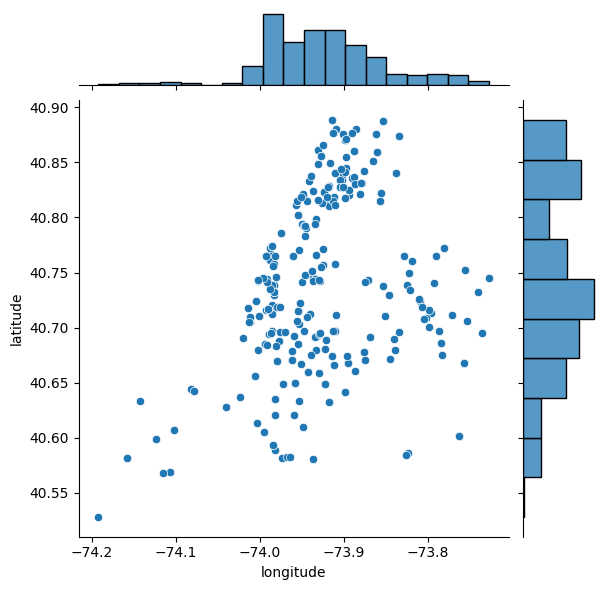

In [37]:
sns.jointplot(data=combined, x="longitude", y="latitude")

This time, it looks like all coordinates are within the allowed ranges for New York City.

In [38]:
# COMMENTED OUT: SOMETIMES GETS STUCK HERE!

#crs={'init':'epsg:4326'}

#boroughs = geopandas.read_file(geoplot.datasets.get_path('nyc_boroughs'))

#geo_df=geopandas.GeoDataFrame(
#    combined,
#    crs=crs,
#    geometry=geopandas.points_from_xy(combined["longitude"], combined["latitude"])
#)

In [39]:
# COMMENTED OUT: SOMETIMES GETS STUCK HERE!

#fig, ax = plt.subplots(figsize=(15,15))
#boroughs.plot(ax=ax, alpha=0.4, color="grey")
#geo_df.plot(ax=ax, markersize=20, column="sat_score", legend=True, cmap="RdYlGn")
#ax.set_title("High Schools and their Average SAT Scores in New York city")
#plt.show()

We would like to find features in the different data sources which are predictive of the average SAT score.

In [40]:
df = data["class_size"]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27611 entries, 0 to 27610
Data columns (total 17 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   CSD                                   27611 non-null  int64  
 1   BOROUGH                               27611 non-null  object 
 2   SCHOOL CODE                           27611 non-null  object 
 3   SCHOOL NAME                           27611 non-null  object 
 4   GRADE                                 26127 non-null  object 
 5   PROGRAM TYPE                          26127 non-null  object 
 6   CORE SUBJECT (MS CORE and 9-12 ONLY)  26127 non-null  object 
 7   CORE COURSE (MS CORE and 9-12 ONLY)   26127 non-null  object 
 8   SERVICE CATEGORY(K-9* ONLY)           26127 non-null  object 
 9   NUMBER OF STUDENTS / SEATS FILLED     26127 non-null  float64
 10  NUMBER OF SECTIONS                    26127 non-null  float64
 11  AVERAGE CLASS S

In [41]:
df[["DBN", "GRADE ", "PROGRAM TYPE"]].value_counts()

DBN     GRADE   PROGRAM TYPE
09X505  09-12   GEN ED          21
20K505  09-12   GEN ED          21
25Q425  09-12   GEN ED          20
30Q445  09-12   GEN ED          20
22K495  09-12   GEN ED          20
                                ..
12X150  05      CTT              1
                GEN ED           1
        0K      CTT              1
                GEN ED           1
17K092  0K-09   SPEC ED          1
Name: count, Length: 12579, dtype: int64

In [42]:
df.rename({"GRADE ": "GRADE"}, axis=1, inplace=True)

In [43]:
df["GRADE"].value_counts()

GRADE
09-12      10644
MS Core     4762
0K-09       1384
0K          1237
01          1185
02          1167
03          1143
04          1140
05          1086
06           846
07           778
08           735
09            20
Name: count, dtype: int64

In [44]:
df["PROGRAM TYPE"].value_counts()

PROGRAM TYPE
GEN ED     14545
CTT         7460
SPEC ED     3653
G&T          469
Name: count, dtype: int64

Only older high school students take the SAT, so we can focus on grades "09-12". Also, we pick the largest program type "GEN ED".

In [45]:
df_reduced = df[(df["GRADE"] == "09-12") & (df["PROGRAM TYPE"] == "GEN ED")]
df_reduced.head(20)

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO,DBN
225,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 9,-,63.0,3.0,21.0,19.0,25.0,STARS,NaN,01M292
226,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 10,-,79.0,3.0,26.3,24.0,31.0,STARS,NaN,01M292
227,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 11,-,38.0,2.0,19.0,16.0,22.0,STARS,NaN,01M292
228,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 12,-,69.0,3.0,23.0,13.0,30.0,STARS,NaN,01M292
229,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,MATH,Integrated Algebra,-,53.0,3.0,17.7,16.0,21.0,STARS,NaN,01M292
231,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,MATH,Geometry,-,32.0,1.0,32.0,32.0,32.0,STARS,NaN,01M292
232,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,MATH,Other Math,-,118.0,6.0,19.7,13.0,27.0,STARS,NaN,01M292
233,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,SCIENCE,Earth Science,-,125.0,4.0,31.3,28.0,35.0,STARS,NaN,01M292
234,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,SCIENCE,Living Environment,-,58.0,2.0,29.0,29.0,29.0,STARS,NaN,01M292
235,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,SCIENCE,Chemistry,-,157.0,8.0,19.6,13.0,24.0,STARS,NaN,01M292


In [46]:
df_reduced["DBN"].value_counts()

DBN
09X505    21
20K505    21
21K525    20
26Q435    20
25Q425    20
          ..
07X162     1
10X459     1
28Q217     1
22K078     1
10X118     1
Name: count, Length: 583, dtype: int64

In [47]:
(df_reduced["DBN"].value_counts() == 1).sum()

80

Now, rows are indexed by "DBN", core subject and core courses. We can average the average class size over these. More features could be obtained by extracting other statistics, but since 80 schools only have a single row, this would be difficult.

In [48]:
df_features = df_reduced[["DBN", "AVERAGE CLASS SIZE"]].groupby("DBN", as_index=False).mean()

In [49]:
df_features.rename({"AVERAGE CLASS SIZE": "class_size"}, axis=1, inplace=True)
data["class_size_features"] = df_features

In [50]:
df = data["demographics"]
df.columns

Index(['DBN', 'Name', 'schoolyear', 'fl_percent', 'frl_percent',
       'total_enrollment', 'prek', 'k', 'grade1', 'grade2', 'grade3', 'grade4',
       'grade5', 'grade6', 'grade7', 'grade8', 'grade9', 'grade10', 'grade11',
       'grade12', 'ell_num', 'ell_percent', 'sped_num', 'sped_percent',
       'ctt_num', 'selfcontained_num', 'asian_num', 'asian_per', 'black_num',
       'black_per', 'hispanic_num', 'hispanic_per', 'white_num', 'white_per',
       'male_num', 'male_per', 'female_num', 'female_per'],
      dtype='object')

In [51]:
df.head()

,DBN,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,...,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per
0,01M015,P.S. 015 ROBERTO CLEMENTE,20052006,89.4,NaN,281,15,36,40,33,...,74,26.3,189,67.3,5,1.8,158.0,56.2,123.0,43.8
1,01M015,P.S. 015 ROBERTO CLEMENTE,20062007,89.4,NaN,243,15,29,39,38,...,68,28.0,153,63.0,4,1.6,140.0,57.6,103.0,42.4
2,01M015,P.S. 015 ROBERTO CLEMENTE,20072008,89.4,NaN,261,18,43,39,36,...,77,29.5,157,60.2,7,2.7,143.0,54.8,118.0,45.2
3,01M015,P.S. 015 ROBERTO CLEMENTE,20082009,89.4,NaN,252,17,37,44,32,...,75,29.8,149,59.1,7,2.8,149.0,59.1,103.0,40.9
4,01M015,P.S. 015 ROBERTO CLEMENTE,20092010,,96.5,208,16,40,28,32,...,67,32.2,118,56.7,6,2.9,124.0,59.6,84.0,40.4


In [52]:
df["schoolyear"].value_counts()

schoolyear
20112012    1509
20102011    1498
20092010    1475
20082009    1441
20072008    1410
20062007    1386
20052006    1356
Name: count, dtype: int64

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10075 entries, 0 to 10074
Data columns (total 38 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   DBN                10075 non-null  object 
 1   Name               10075 non-null  object 
 2   schoolyear         10075 non-null  int64  
 3   fl_percent         8560 non-null   object 
 4   frl_percent        4482 non-null   float64
 5   total_enrollment   10075 non-null  int64  
 6   prek               4712 non-null   object 
 7   k                  5882 non-null   object 
 8   grade1             5881 non-null   object 
 9   grade2             5851 non-null   object 
 10  grade3             5779 non-null   object 
 11  grade4             5741 non-null   object 
 12  grade5             5777 non-null   object 
 13  grade6             4517 non-null   object 
 14  grade7             4203 non-null   object 
 15  grade8             4085 non-null   object 
 16  grade9             397

In [54]:
df_reduced = df.query("schoolyear == 20112012")
df_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1509 entries, 6 to 10074
Data columns (total 38 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   DBN                1509 non-null   object 
 1   Name               1509 non-null   object 
 2   schoolyear         1509 non-null   int64  
 3   fl_percent         0 non-null      object 
 4   frl_percent        1509 non-null   float64
 5   total_enrollment   1509 non-null   int64  
 6   prek               1509 non-null   object 
 7   k                  1509 non-null   object 
 8   grade1             1509 non-null   object 
 9   grade2             1509 non-null   object 
 10  grade3             1509 non-null   object 
 11  grade4             1509 non-null   object 
 12  grade5             1509 non-null   object 
 13  grade6             1509 non-null   object 
 14  grade7             1509 non-null   object 
 15  grade8             1509 non-null   object 
 16  grade9             1509 non-

In [55]:
[x for x in df.columns if x.endswith("_per")]

['asian_per',
 'black_per',
 'hispanic_per',
 'white_per',
 'male_per',
 'female_per']

In [56]:
names = ['DBN', 'asian_per', 'black_per', 'hispanic_per', 'white_per', 'male_per', 'female_per', 'frl_percent', 'ell_percent', 'sped_percent', 'total_enrollment']
data["demographics_features"] = df_reduced[names]

In [57]:
data["demographics_features"]

,DBN,asian_per,black_per,hispanic_per,white_per,male_per,female_per,frl_percent,ell_percent,sped_percent,total_enrollment
6,01M015,6.3,33.3,57.7,2.1,51.3,48.7,89.4,10.6,21.2,189
13,01M019,15.5,24.7,48.2,8.5,44.8,55.2,61.5,10.1,18.0,328
20,01M020,30.4,8.8,57.0,2.6,52.7,47.3,92.5,20.4,15.5,626
27,01M034,5.5,22.4,68.6,2.0,50.9,49.1,99.7,8.5,26.4,401
35,01M063,5.1,23.3,62.5,8.5,55.1,44.9,78.9,3.4,25.6,176
...,...,...,...,...,...,...,...,...,...,...,...
10046,32K549,0.5,28.3,68.7,1.8,48.4,51.6,75.1,18.2,18.4,434
10053,32K552,1.5,26.4,70.4,1.0,54.5,45.5,77.1,23.9,22.1,398
10060,32K554,5.3,12.9,79.5,1.5,52.1,47.9,81.4,2.7,4.9,263
10067,32K556,0.9,21.2,77.3,0.0,53.2,46.8,88.0,18.2,18.6,462


In [58]:
df = data["graduation"]
df["Cohort"].value_counts()

Cohort
2006 Aug    4131
2006        4130
2005        3963
2004        3708
2003        3432
2002        3095
2001        2637
Name: count, dtype: int64

In [59]:
df["Demographic"].value_counts()

Demographic
Total Cohort                   2493
English Proficient Students    2471
Special Education Students     2471
General Education Students     2471
Male                           2412
Black                          2403
Female                         2397
Hispanic                       2385
English Language Learners      2036
Asian                          1780
White                          1777
Name: count, dtype: int64

We select the latest cohort and "Total Cohort" demographic.

In [60]:
df_reduced = df.query("Cohort == '2006' and Demographic == 'Total Cohort'")
df_reduced["DBN"].value_counts()

DBN
01M292    1
17K539    1
17K625    1
17K600    1
17K590    1
         ..
08X650    1
08X560    1
08X540    1
08X530    1
32K564    1
Name: count, Length: 405, dtype: int64

In [61]:
df_reduced.head()

,Demographic,DBN,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,...,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort
3,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006,78,43,55.1,36,46.2,83.7,...,36,46.2,83.7,7,9.0,16.3,16,20.5,11,14.1
10,Total Cohort,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,2006,124,53,42.7,42,33.9,79.2,...,34,27.4,64.2,11,8.9,20.8,46,37.1,20,16.1
17,Total Cohort,01M450,EAST SIDE COMMUNITY SCHOOL,2006,90,70,77.8,67,74.4,95.7,...,67,74.4,95.7,3,3.3,4.3,15,16.7,5,5.6
24,Total Cohort,01M509,MARTA VALLE HIGH SCHOOL,2006,84,47,56.0,40,47.6,85.1,...,23,27.4,48.9,7,8.3,14.9,25,29.8,5,6.0
31,Total Cohort,01M515,LOWER EAST SIDE PREPARATORY HIGH SCHO,2006,193,105,54.4,91,47.2,86.7,...,22,11.4,21.0,14,7.3,13.3,53,27.5,35,18.1


In [62]:
df_reduced.columns

Index(['Demographic', 'DBN', 'School Name', 'Cohort', 'Total Cohort',
       'Total Grads - n', 'Total Grads - % of cohort', 'Total Regents - n',
       'Total Regents - % of cohort', 'Total Regents - % of grads',
       'Advanced Regents - n', 'Advanced Regents - % of cohort',
       'Advanced Regents - % of grads', 'Regents w/o Advanced - n',
       'Regents w/o Advanced - % of cohort',
       'Regents w/o Advanced - % of grads', 'Local - n', 'Local - % of cohort',
       'Local - % of grads', 'Still Enrolled - n',
       'Still Enrolled - % of cohort', 'Dropped Out - n',
       'Dropped Out - % of cohort'],
      dtype='object')

In [63]:
names = ["DBN", "Total Cohort"] + [x for x in df_reduced.columns if x.endswith("% of cohort")]
names

['DBN',
 'Total Cohort',
 'Total Grads - % of cohort',
 'Total Regents - % of cohort',
 'Advanced Regents - % of cohort',
 'Regents w/o Advanced - % of cohort',
 'Local - % of cohort',
 'Still Enrolled - % of cohort',
 'Dropped Out - % of cohort']

In [64]:
new_names = ["DBN", "total_cohort", "grads_per", "regents_per", "adv_regents_per", "local_per", "enrolled_per"]
names = names[:5] + names[6:8]
grad_colmap = dict(zip(names, new_names))

In [65]:
grad_colmap

{'DBN': 'DBN',
 'Total Cohort': 'total_cohort',
 'Total Grads - % of cohort': 'grads_per',
 'Total Regents - % of cohort': 'regents_per',
 'Advanced Regents - % of cohort': 'adv_regents_per',
 'Local - % of cohort': 'local_per',
 'Still Enrolled - % of cohort': 'enrolled_per'}

In [66]:
df_features = df_reduced[list(grad_colmap.keys())].rename(grad_colmap, axis=1)
df_features.head()

,DBN,total_cohort,grads_per,regents_per,adv_regents_per,local_per,enrolled_per
3,01M292,78,55.1,46.2,0.0,9.0,20.5
10,01M448,124,42.7,33.9,6.5,8.9,37.1
17,01M450,90,77.8,74.4,0.0,3.3,16.7
24,01M509,84,56.0,47.6,20.2,8.3,29.8
31,01M515,193,54.4,47.2,35.8,7.3,27.5


In [67]:
data["graduation_features"] = df_features

In [68]:
data.keys()

dict_keys(['hs_directory', 'combined_cleaned_nomissing', 'sat_results', 'ap_2010', 'graduation', 'class_size', 'sat_results_2010', 'combined_cleaned_withmissing', 'demographics', 'survey', 'class_size_features', 'demographics_features', 'graduation_features'])

In [69]:
data["survey"].head()

,DBN,rr_s,rr_t,rr_p,N_s,N_t,N_p,saf_p_11,com_p_11,eng_p_11,...,eng_t_11,aca_t_11,saf_s_11,com_s_11,eng_s_11,aca_s_11,saf_tot_11,com_tot_11,eng_tot_11,aca_tot_11
0,01M015,NaN,88,60,NaN,22.0,90.0,8.5,7.6,7.5,...,7.6,7.9,NaN,NaN,NaN,NaN,8.0,7.7,7.5,7.9
1,01M019,NaN,100,60,NaN,34.0,161.0,8.4,7.6,7.6,...,8.9,9.1,NaN,NaN,NaN,NaN,8.5,8.1,8.2,8.4
2,01M020,NaN,88,73,NaN,42.0,367.0,8.9,8.3,8.3,...,6.8,7.5,NaN,NaN,NaN,NaN,8.2,7.3,7.5,8.0
3,01M034,89.0,73,50,145.0,29.0,151.0,8.8,8.2,8.0,...,6.8,7.8,6.2,5.9,6.5,7.4,7.3,6.7,7.1,7.9
4,01M063,NaN,100,60,NaN,23.0,90.0,8.7,7.9,8.1,...,7.8,8.1,NaN,NaN,NaN,NaN,8.5,7.6,7.9,8.0


In [70]:
df = data["ap_2010"]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258 entries, 0 to 257
Data columns (total 5 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   DBN                                   258 non-null    object 
 1   SchoolName                            258 non-null    object 
 2   AP Test Takers                        233 non-null    float64
 3   Total Exams Taken                     233 non-null    float64
 4   Number of Exams with scores 3 4 or 5  151 non-null    float64
dtypes: float64(3), object(2)
memory usage: 10.2+ KB


In [71]:
df.head(10)

,DBN,SchoolName,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5
0,01M448,UNIVERSITY NEIGHBORHOOD H.S.,39.0,49.0,10.0
1,01M450,EAST SIDE COMMUNITY HS,19.0,21.0,NaN
2,01M515,LOWER EASTSIDE PREP,24.0,26.0,24.0
3,01M539,"NEW EXPLORATIONS SCI,TECH,MATH",255.0,377.0,191.0
4,02M296,High School of Hospitality Management,NaN,NaN,NaN
5,02M298,Pace High School,21.0,21.0,NaN
6,02M300,"Urban Assembly School of Design and Construction,",99.0,117.0,10.0
7,02M303,"Facing History School, The",42.0,44.0,NaN
8,02M305,"Urban Assembly Academy of Government and Law, The",25.0,37.0,15.0
9,02M308,Lower Manhattan Arts Academy,NaN,NaN,NaN


In [72]:
names = ["DBN"] + list(df.columns)[2:]
names

['DBN',
 'AP Test Takers ',
 'Total Exams Taken',
 'Number of Exams with scores 3 4 or 5']

In [73]:
new_names = ["DBN", "ap_test_takers", "ap_exams_taken", "ap_exams_scores345"]
ap_map = dict(zip(names, new_names))
df_features = df[names].rename(ap_map, axis=1)
df_features.head()

,DBN,ap_test_takers,ap_exams_taken,ap_exams_scores345
0,01M448,39.0,49.0,10.0
1,01M450,19.0,21.0,NaN
2,01M515,24.0,26.0,24.0
3,01M539,255.0,377.0,191.0
4,02M296,NaN,NaN,NaN


In [74]:
data["ap_2010_features"] = df_features

In [75]:
df = data["hs_directory"]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435 entries, 0 to 434
Data columns (total 66 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   DBN                               435 non-null    object 
 1   school_name                       435 non-null    object 
 2   borough                           435 non-null    object 
 3   building_code                     435 non-null    object 
 4   phone_number                      435 non-null    object 
 5   fax_number                        423 non-null    object 
 6   grade_span_min                    432 non-null    float64
 7   grade_span_max                    435 non-null    int64  
 8   expgrade_span_min                 31 non-null     float64
 9   expgrade_span_max                 33 non-null     float64
 10  bus                               434 non-null    object 
 11  subway                            358 non-null    object 
 12  primary_

We select a subset of columns which are potentially useful features for our analysis.

Note that we ignore a number of columns which could be useful (for example, the "partner_*" columns could be informative about the academic and financial situation of a school), because they contain text, which is harder to use as a feature.

In [76]:
# Collect names of potentially useful columns
names = ["DBN", "total_students", "latitude", "longitude", "number_programs"]
data["hs_dir_features"] = df[names].copy()

At this point, we have collected potentially useful features (in order to explain SAT scores in `data["sat_results"]`) in the tables 'survey', 'class_size_features', 'demographics_features', 'graduation_features', 'survey', 'ap_2010_features', and 'hs_dir_features'. All of these have one row per "DBN" entry.

In [77]:
feature_tables = [name for name in data.keys() if name.endswith("_features")] + ["survey"]
for name in feature_tables:
    print(f"{name}: {data[name].shape} -- {data[name].columns}")

class_size_features: (583, 2) -- Index(['DBN', 'class_size'], dtype='object')
demographics_features: (1509, 11) -- Index(['DBN', 'asian_per', 'black_per', 'hispanic_per', 'white_per',
       'male_per', 'female_per', 'frl_percent', 'ell_percent', 'sped_percent',
       'total_enrollment'],
      dtype='object')
graduation_features: (405, 7) -- Index(['DBN', 'total_cohort', 'grads_per', 'regents_per', 'adv_regents_per',
       'local_per', 'enrolled_per'],
      dtype='object')
ap_2010_features: (258, 4) -- Index(['DBN', 'ap_test_takers', 'ap_exams_taken', 'ap_exams_scores345'], dtype='object')
hs_dir_features: (435, 5) -- Index(['DBN', 'total_students', 'latitude', 'longitude', 'number_programs'], dtype='object')
survey: (1702, 23) -- Index(['DBN', 'rr_s', 'rr_t', 'rr_p', 'N_s', 'N_t', 'N_p', 'saf_p_11',
       'com_p_11', 'eng_p_11', 'aca_p_11', 'saf_t_11', 'com_t_11', 'eng_t_11',
       'aca_t_11', 'saf_s_11', 'com_s_11', 'eng_s_11', 'aca_s_11',
       'saf_tot_11', 'com_tot_11', 'en

In [78]:
print(f"sat_results: {data['sat_results'].shape}")

sat_results: (478, 7)


Now, we join all data into a single table `combined`. We use left joins in order not to lose any rows in the "sat_results" table.

In [79]:
df = data["sat_results"]
names = ["DBN"] + list(df.columns)[2:]
names_new = ["DBN", "sat_num_takers", "sat_crit_reading", "sat_math", "sat_writing", "sat_score"]
sat_map = dict(zip(names, names_new))
combined = df[names].rename(sat_map, axis=1)
combined

,DBN,sat_num_takers,sat_crit_reading,sat_math,sat_writing,sat_score
0,01M292,29.0,355.0,404.0,363.0,1122.0
1,01M448,91.0,383.0,423.0,366.0,1172.0
2,01M450,70.0,377.0,402.0,370.0,1149.0
3,01M458,7.0,414.0,401.0,359.0,1174.0
4,01M509,44.0,390.0,433.0,384.0,1207.0
...,...,...,...,...,...,...
473,75X012,NaN,NaN,NaN,NaN,NaN
474,75X754,NaN,NaN,NaN,NaN,NaN
475,79M645,NaN,NaN,NaN,NaN,NaN
476,79Q950,8.0,496.0,400.0,426.0,1322.0


In [80]:
for name in feature_tables:
    combined = combined.merge(data[name], on="DBN", how="left")

combined

,DBN,sat_num_takers,sat_crit_reading,sat_math,sat_writing,sat_score,class_size,asian_per,black_per,hispanic_per,...,eng_t_11,aca_t_11,saf_s_11,com_s_11,eng_s_11,aca_s_11,saf_tot_11,com_tot_11,eng_tot_11,aca_tot_11
0,01M292,29.0,355.0,404.0,363.0,1122.0,22.564286,14.0,29.1,53.8,...,6.1,6.5,6.0,5.6,6.1,6.7,6.7,6.2,6.6,7.0
1,01M448,91.0,383.0,423.0,366.0,1172.0,22.231250,29.2,22.6,45.9,...,6.6,7.3,6.0,5.7,6.3,7.0,6.8,6.3,6.7,7.2
2,01M450,70.0,377.0,402.0,370.0,1149.0,21.200000,9.7,23.9,55.4,...,8.0,8.8,NaN,NaN,NaN,NaN,7.9,7.9,7.9,8.4
3,01M458,7.0,414.0,401.0,359.0,1174.0,23.000000,2.2,34.4,59.4,...,8.9,8.9,6.8,6.1,6.1,6.8,7.8,7.1,7.2,7.8
4,01M509,44.0,390.0,433.0,384.0,1207.0,23.571429,9.3,31.6,56.9,...,6.1,6.8,6.4,5.9,6.4,7.0,6.9,6.2,6.6,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474,75X012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.2,5.3,5.7,5.7,6.8,6.5,5.2,5.8,5.8,5.8
475,75X754,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.6,7.1,6.8,6.6,7.6,7.7,7.2,6.9,7.3,7.5
476,79M645,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
477,79Q950,8.0,496.0,400.0,426.0,1322.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [81]:
combined["DBN"].value_counts()

DBN
04M610    2
01M292    1
18K673    1
18K637    1
18K635    1
         ..
08X650    1
08X560    1
08X540    1
08X537    1
79X490    1
Name: count, Length: 478, dtype: int64

In [82]:
combined.query("DBN == '04M610'")

,DBN,sat_num_takers,sat_crit_reading,sat_math,sat_writing,sat_score,class_size,asian_per,black_per,hispanic_per,...,eng_t_11,aca_t_11,saf_s_11,com_s_11,eng_s_11,aca_s_11,saf_tot_11,com_tot_11,eng_tot_11,aca_tot_11
95,04M610,70.0,432.0,446.0,448.0,1326.0,25.711765,5.1,31.2,60.1,...,8.5,9.0,7.5,6.6,7.2,8.3,8.4,7.7,7.8,8.5
96,04M610,70.0,432.0,446.0,448.0,1326.0,25.711765,5.1,31.2,60.1,...,8.5,9.0,7.5,6.6,7.2,8.3,8.4,7.7,7.8,8.5


In [83]:
slice = combined.iloc[95:97, :]
neq_ind = slice.iloc[0, :] != slice.iloc[1, :]
slice.loc[:, neq_ind]

,ap_test_takers,ap_exams_taken,ap_exams_scores345
95,41.0,55.0,29.0
96,NaN,NaN,NaN


In [84]:
combined.drop(96, inplace=True)
combined.shape

(478, 52)

Finally, we need to do something about missing values. Once this is done, we could use a predictive method, like XGBoost, in order to predict SAT scores from the other features, thereby identifying predictive features.

In [85]:
combined.iloc[:, 1:6].isnull().sum(axis=1).value_counts()

0    421
5     57
Name: count, dtype: int64

In [86]:
# Drop 57 rows for which the SAT data is (completely) missing
sat_names = [x for x in combined.columns if x.startswith("sat_")]
combined = combined.dropna(subset=sat_names, how="all")
combined

,DBN,sat_num_takers,sat_crit_reading,sat_math,sat_writing,sat_score,class_size,asian_per,black_per,hispanic_per,...,eng_t_11,aca_t_11,saf_s_11,com_s_11,eng_s_11,aca_s_11,saf_tot_11,com_tot_11,eng_tot_11,aca_tot_11
0,01M292,29.0,355.0,404.0,363.0,1122.0,22.564286,14.0,29.1,53.8,...,6.1,6.5,6.0,5.6,6.1,6.7,6.7,6.2,6.6,7.0
1,01M448,91.0,383.0,423.0,366.0,1172.0,22.231250,29.2,22.6,45.9,...,6.6,7.3,6.0,5.7,6.3,7.0,6.8,6.3,6.7,7.2
2,01M450,70.0,377.0,402.0,370.0,1149.0,21.200000,9.7,23.9,55.4,...,8.0,8.8,NaN,NaN,NaN,NaN,7.9,7.9,7.9,8.4
3,01M458,7.0,414.0,401.0,359.0,1174.0,23.000000,2.2,34.4,59.4,...,8.9,8.9,6.8,6.1,6.1,6.8,7.8,7.1,7.2,7.8
4,01M509,44.0,390.0,433.0,384.0,1207.0,23.571429,9.3,31.6,56.9,...,6.1,6.8,6.4,5.9,6.4,7.0,6.9,6.2,6.6,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
467,32K556,23.0,347.0,358.0,350.0,1055.0,25.060000,0.9,21.2,77.3,...,7.6,7.7,6.6,6.0,6.7,7.3,7.4,7.0,7.4,7.7
468,32K564,24.0,359.0,317.0,358.0,1034.0,24.964286,0.3,35.9,61.5,...,7.5,8.0,8.3,6.5,7.6,8.1,8.6,7.0,7.7,8.1
472,75Q811,32.0,429.0,444.0,433.0,1306.0,NaN,NaN,NaN,NaN,...,7.8,8.2,8.1,7.3,8.4,8.2,8.5,7.8,8.0,8.2
477,79Q950,8.0,496.0,400.0,426.0,1322.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [87]:
combined.isnull().sum(axis=1).value_counts()

0     136
3      90
1      62
7      43
8      22
9      21
4      13
5      13
24      7
6       3
13      3
12      3
46      2
2       1
14      1
32      1
Name: count, dtype: int64

In [88]:
# At this point, we can convert the type to integer
sat_cols = [x for x in combined.columns if x.startswith("sat_")]
for name in sat_cols:
    combined.loc[:, name] = combined[name].astype(int)

In [89]:
# There are 10 rows with 23 or more missing values. Let us drop these rows
combined = combined.dropna(thresh=29)

In [90]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 411 entries, 0 to 468
Data columns (total 52 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   DBN                 411 non-null    object 
 1   sat_num_takers      411 non-null    float64
 2   sat_crit_reading    411 non-null    float64
 3   sat_math            411 non-null    float64
 4   sat_writing         411 non-null    float64
 5   sat_score           411 non-null    float64
 6   class_size          401 non-null    float64
 7   asian_per           411 non-null    float64
 8   black_per           411 non-null    float64
 9   hispanic_per        411 non-null    float64
 10  white_per           411 non-null    float64
 11  male_per            411 non-null    float64
 12  female_per          411 non-null    float64
 13  frl_percent         411 non-null    float64
 14  ell_percent         411 non-null    float64
 15  sped_percent        411 non-null    float64
 16  total_enrollm

In [91]:
def plot_null_matrix(df, figsize=(18,15)):
    # initiate the figure
    plt.figure(figsize=figsize)
    # create a boolean dataframe based on whether values are null
    df_null = df.isnull()
    # create a heatmap of the boolean dataframe
    sns.heatmap(~df_null, cbar=False, yticklabels=False)
    plt.xticks(rotation=90, size='x-large')
    plt.show()

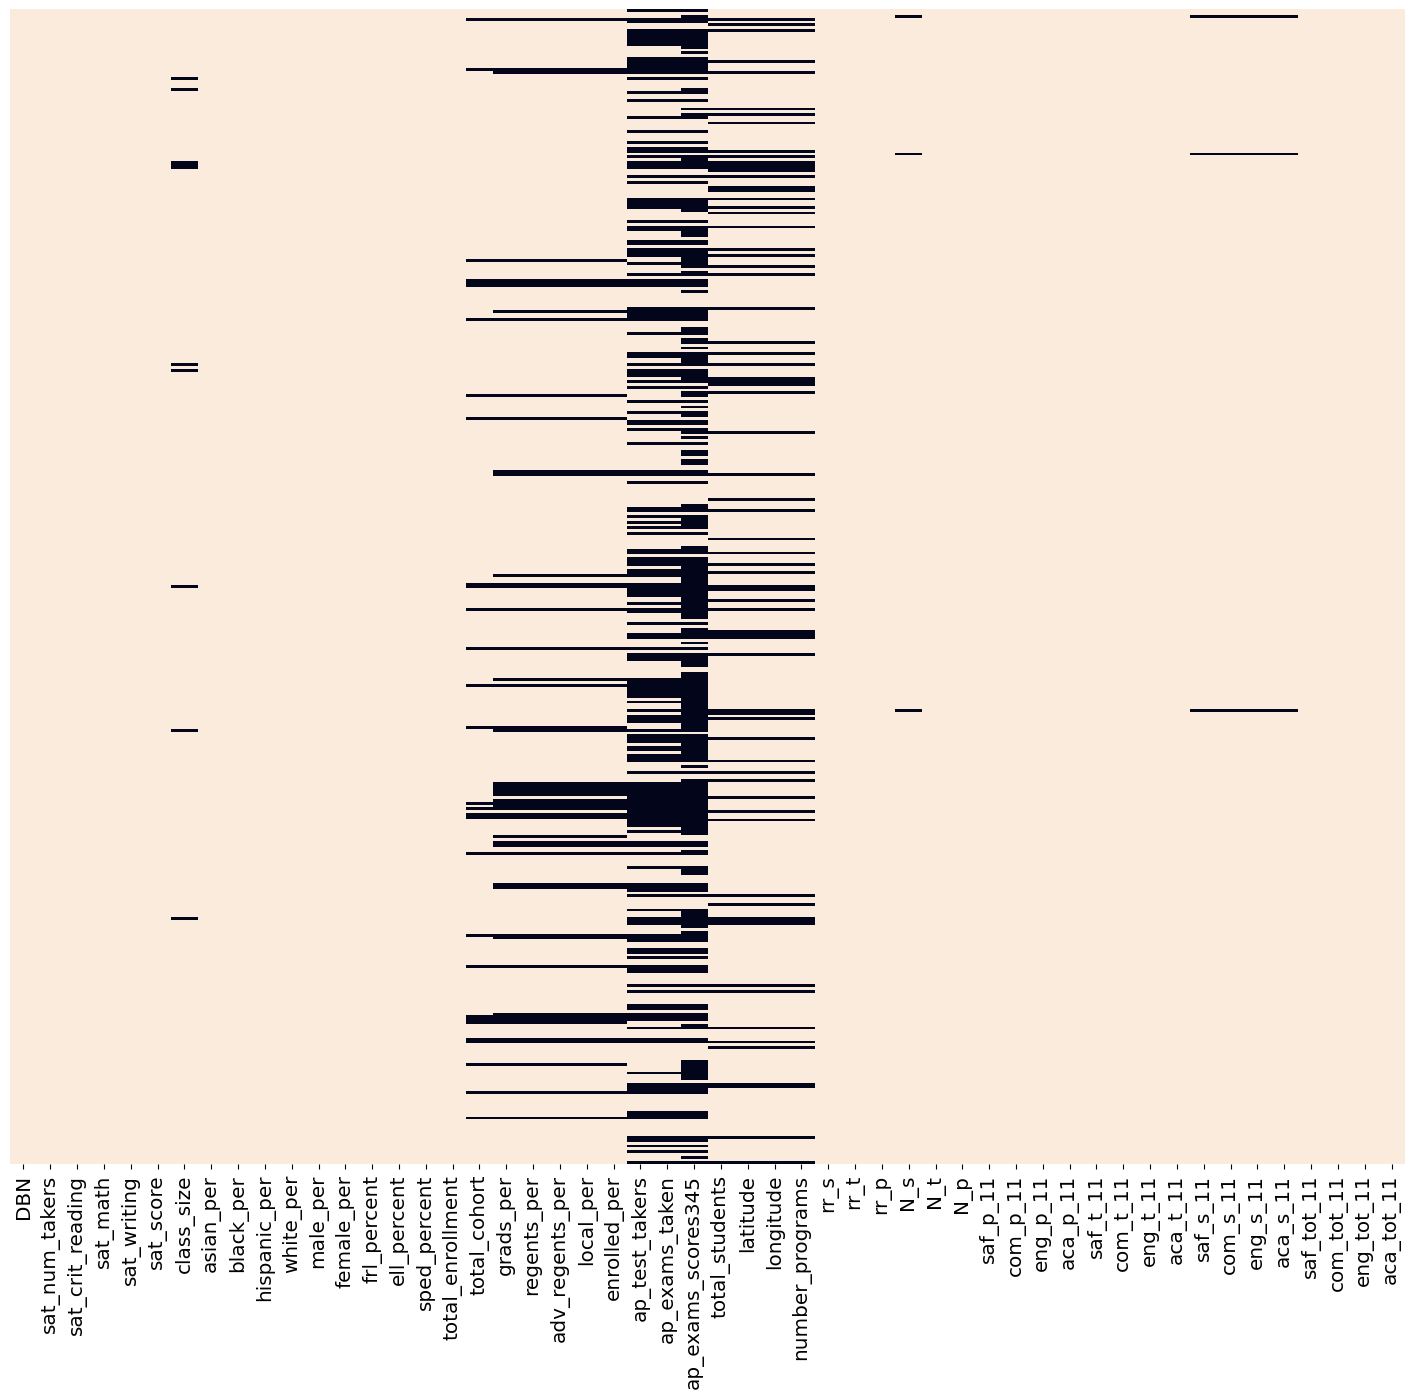

In [92]:
plot_null_matrix(combined.sort_values("DBN"))

We do mean imputation for columns with few missing values (10 or less).

In [93]:
indic = combined.isnull().sum()
mean_imput_cols = indic[(indic > 0) & (indic <= 10)].index
mean_vals = combined[mean_imput_cols].mean()
combined = combined.fillna(value=mean_vals)

In [94]:
indic = combined.isnull().sum()
indic[indic > 0]

total_cohort           30
grads_per              51
regents_per            51
adv_regents_per        51
local_per              51
enrolled_per           51
ap_test_takers        181
ap_exams_taken        181
ap_exams_scores345    260
total_students         73
latitude               73
longitude              73
number_programs        73
dtype: int64

The remaining 13 columns with 30 or more missing values are from:

* "graduation": "total_cohort", "grads_per", "regents_per", "adv_regents_per", "local_per", "enrolled_per"
* "ap_2010": "ap_test_takers", "ap_exams_taken", "ap_exams_scores345"
* "hs_directory": "total_students", "latitude", "longitude", "number_programs"

It does not make sense to impute missing values. We'd rather not use these columns as features when predicting the SAT score.

At this point, we could try to predict the SAT scores from the features we extracted and cleaned. Some predictive methods include feature selection, which would allow us to rank our potential features. A weak alternative is to compute correlations, which we do next. We also include the 13 columns we just removed, just to be safe.

In [95]:
feat_cols = [x for x in combined.columns if not (x == "DBN" or x.startswith("sat_"))] + ["sat_score"]
correlations = combined[feat_cols].corr()["sat_score"][:-1].sort_values(ascending=False)
correlations

adv_regents_per       0.782133
white_per             0.652793
regents_per           0.637984
ap_test_takers        0.617711
ap_exams_scores345    0.614752
ap_exams_taken        0.607152
grads_per             0.546369
asian_per             0.546186
N_p                   0.433367
N_s                   0.429197
total_students        0.409480
class_size            0.388986
total_enrollment      0.379025
saf_t_11              0.316960
total_cohort          0.303301
N_t                   0.299794
aca_s_11              0.298915
saf_tot_11            0.294797
rr_s                  0.290510
saf_s_11              0.288578
aca_tot_11            0.189022
eng_s_11              0.182986
com_s_11              0.174754
aca_t_11              0.145597
saf_p_11              0.115977
number_programs       0.115618
eng_tot_11            0.109144
rr_p                  0.105018
com_t_11              0.105011
female_per            0.103216
com_tot_11            0.099947
eng_t_11              0.058935
aca_p_11

In [96]:
correlations[correlations > 0.5].index

Index(['adv_regents_per', 'white_per', 'regents_per', 'ap_test_takers',
       'ap_exams_scores345', 'ap_exams_taken', 'grads_per', 'asian_per'],
      dtype='object')

Of the columns with correlation `> 0.5` with "sat_score", only two ("white_per", "asian_per") have not been removed above. It may be useful to revise the decision to remove columns from the "graduation" table, and instead impute the 51 missing values, which would retain columns "adv_regents_per", "regents_per", "grads_per". The columns of the "ap_2010" table cannot be retained, since too many values are missing there.

For the negatively correlated columns, we have:

* "frl_percent": percentage of students eligible for free or reduced lunch based on household income.
* "ell_percent": percentage of students who are learning to speak English.
* "sped_percent": percentage of students who receive specialized instruction to accommodate special needs such as learning or physical disabilities.

In [97]:
# Let us extend mean imputation to columns from "graduation", which have missing values in up to 51 rows.

indic = combined.isnull().sum()
mean_imput_cols = indic[(indic > 0) & (indic <= 51)].index
print(mean_imput_cols)
mean_vals = combined[mean_imput_cols].mean()
combined = combined.fillna(value=mean_vals)

Index(['total_cohort', 'grads_per', 'regents_per', 'adv_regents_per',
       'local_per', 'enrolled_per'],
      dtype='object')


In [98]:
indic = combined.isnull().sum()
indic[indic > 0]

ap_test_takers        181
ap_exams_taken        181
ap_exams_scores345    260
total_students         73
latitude               73
longitude              73
number_programs        73
dtype: int64

In [99]:
indic = combined.isnull().sum()
complete_names = indic[indic == 0].index
combined_complete = combined[complete_names]

combined.to_csv(data_path / "combined_cleaned_withmissing.csv", index=False)
combined_complete.to_csv(data_path / "combined_cleaned_nomissing.csv", index=False)

In [100]:
feat_cols = [x for x in combined.columns if not (x == "DBN" or x.startswith("sat_"))] + ["sat_score"]
correlations = combined[feat_cols].corr()["sat_score"][:-1].sort_values(ascending=False)
correlations

adv_regents_per       0.752255
white_per             0.652793
ap_test_takers        0.617711
ap_exams_scores345    0.614752
regents_per           0.613613
ap_exams_taken        0.607152
asian_per             0.546186
grads_per             0.525497
N_p                   0.433367
N_s                   0.429197
total_students        0.409480
class_size            0.388986
total_enrollment      0.379025
saf_t_11              0.316960
N_t                   0.299794
aca_s_11              0.298915
total_cohort          0.297629
saf_tot_11            0.294797
rr_s                  0.290510
saf_s_11              0.288578
aca_tot_11            0.189022
eng_s_11              0.182986
com_s_11              0.174754
aca_t_11              0.145597
saf_p_11              0.115977
number_programs       0.115618
eng_tot_11            0.109144
rr_p                  0.105018
com_t_11              0.105011
female_per            0.103216
com_tot_11            0.099947
eng_t_11              0.058935
aca_p_11

Let us look at scatterplots for the most positively correlated columns.

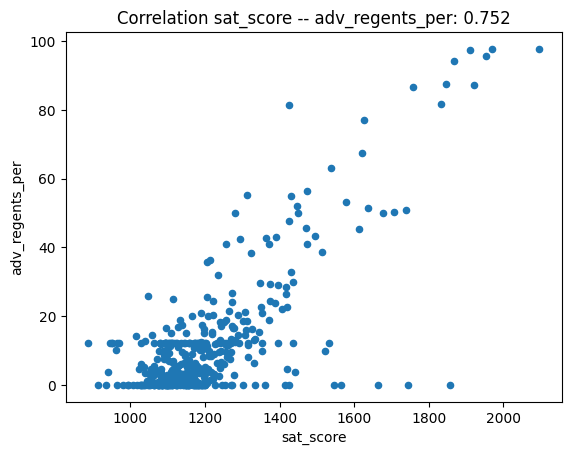

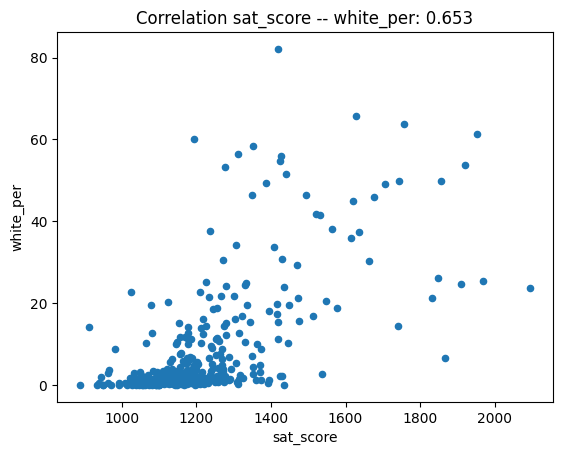

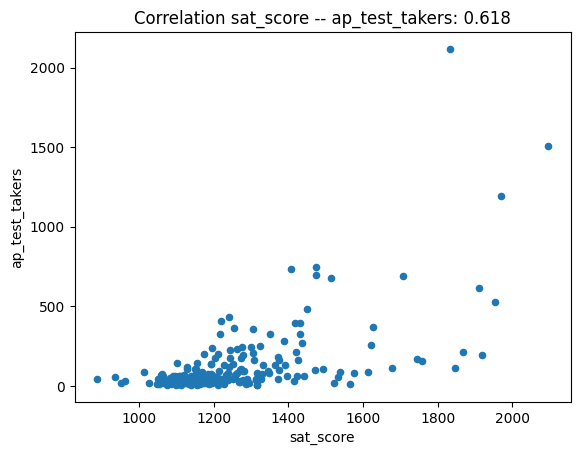

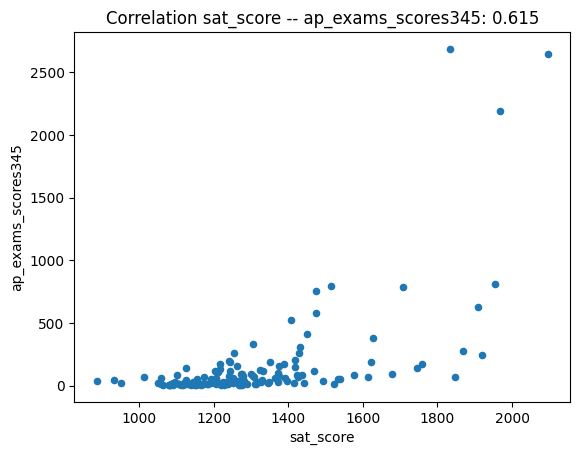

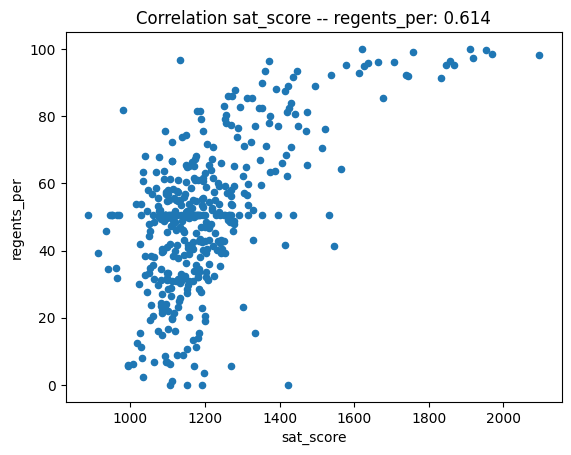

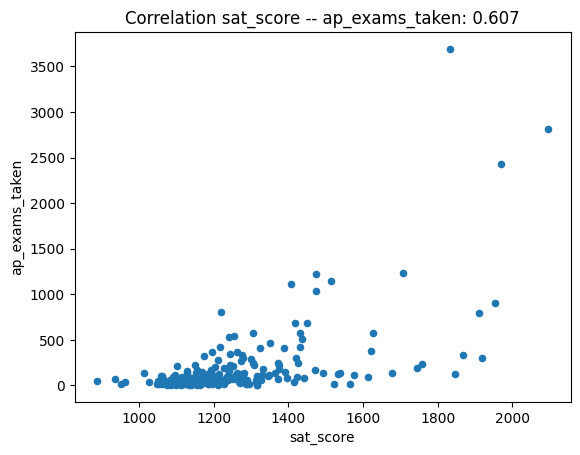

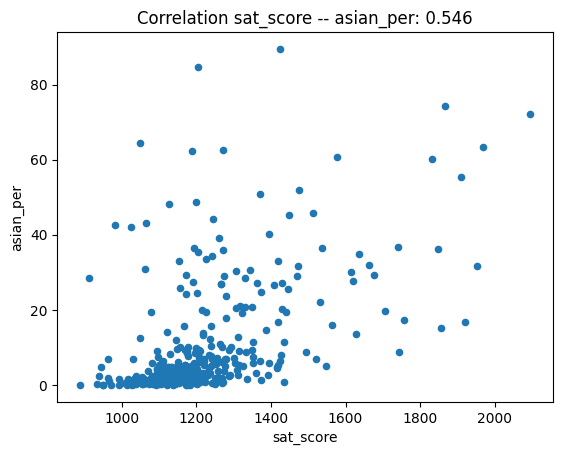

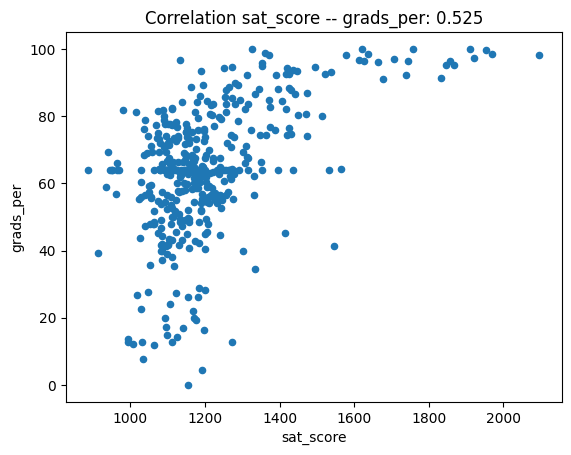

In [101]:
for name in correlations[:8].index:
    combined.plot.scatter(x="sat_score", y=name, title=f"Correlation sat_score -- {name}: {correlations[name]:.3f}")
    plt.show()

The same for the most negatively correlated columns.

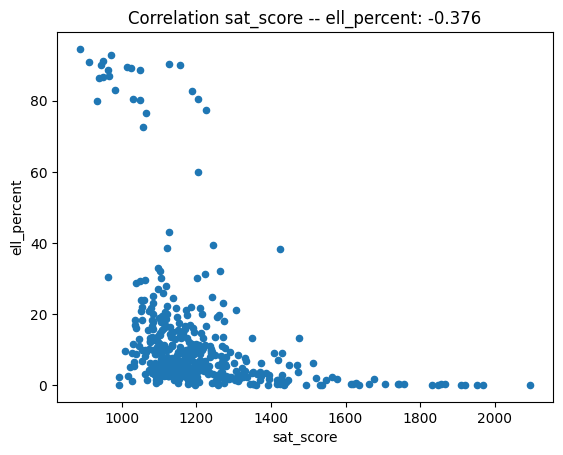

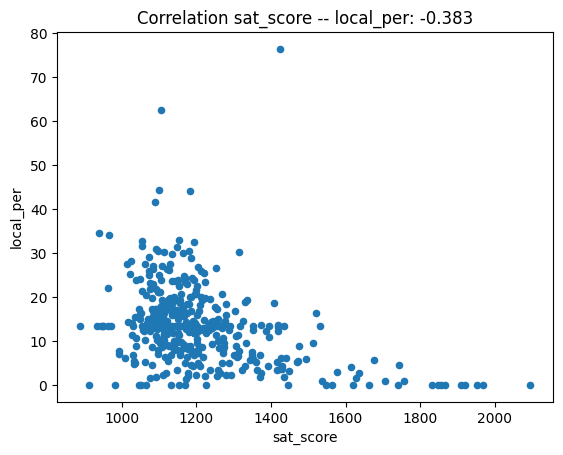

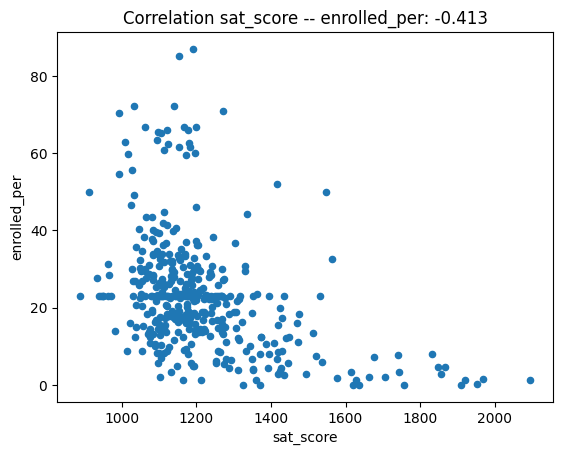

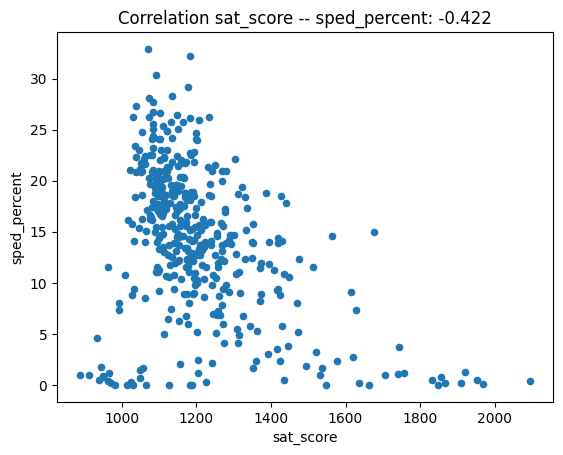

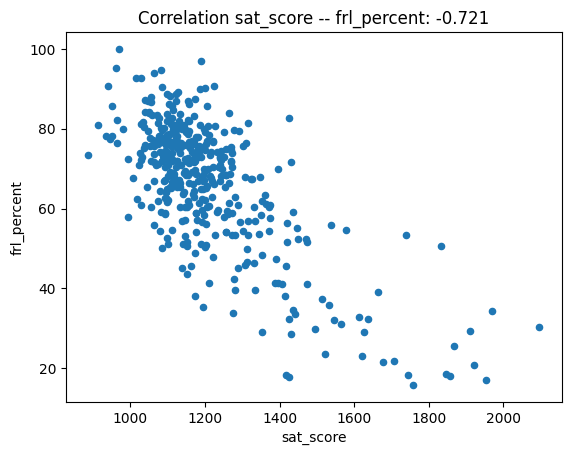

In [102]:
for name in correlations[-5:].index:
    combined.plot.scatter(x="sat_score", y=name, title=f"Correlation sat_score -- {name}: {correlations[name]:.3f}")
    plt.show()

Let us drill down on correlations between "ell_percent" (percentage of students who are learning to speak English) and the different SAT scores.

In [103]:
names = [x for x in combined.columns if x.startswith("sat_")] + ["ell_percent"]
ell_corr = combined[names].corr()["ell_percent"][:-1].sort_values(ascending=False)
ell_corr

sat_num_takers     -0.068536
sat_math           -0.211158
sat_score          -0.376087
sat_writing        -0.426968
sat_crit_reading   -0.477379
Name: ell_percent, dtype: float64

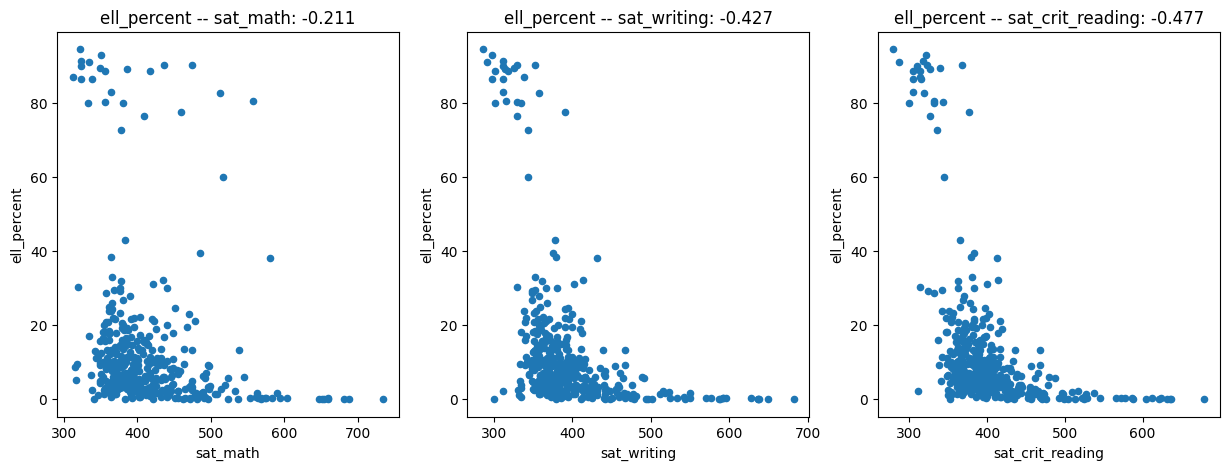

In [104]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for name, ax in zip(["sat_math", "sat_writing", "sat_crit_reading"], axes):
    combined.plot.scatter(x=name, y="ell_percent", title=f"ell_percent -- {name}: {ell_corr[name]:.3f}", ax=ax)
plt.show()

We see that the negative correlation between "ell_percent" and "sat_score" can be explained by two of three parts of the SAT to be strongly dependent on English language knowledge.

At this point, it is high time to fit some predictors to potential features we obtained. Here are some ideas of what we could compare:

* Use all features in `combined_complete`
* Use only features positively or negative correlated above a threshold (0.5 or 0.3)
* Use 1-2 different methods (e.g., XGBoost, sparse linear)

We could also check how well a trained predictor performs on the SAT results data from 2010 (while fitting was done on the data from 2012).

TODO!!!